In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import json
import time

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 전처리 완료된 데이터 불러오기

In [53]:
X_train = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/data/X_train.csv', index_col=[0])
X_test = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/data/X_test.csv', index_col=[0])
y_train = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/data/y_train.csv', index_col=[0])
y_test = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/data/y_test.csv', index_col=[0])

word_index_json = open('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/data/word_index_vocab.json', 'r').read()
word_index_vocab = json.loads(word_index_json)

In [54]:
X_train_split = X_train['댓글'].apply(list).tolist()
X_test_split = X_test['댓글'].apply(list).tolist()

## 2. 단어 사전을 이용한 토큰화와 패딩화

In [56]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index_vocab

X_train_sequences = tokenizer.texts_to_sequences(X_train_split)
X_test_sequences = tokenizer.texts_to_sequences(X_test_split)

In [57]:
train = pad_sequences(X_train_sequences, padding='post', maxlen=400)
test = pad_sequences(X_test_sequences, padding='post', maxlen=400)

In [58]:
# 데이터가 추가되었는지 확인하고 진행하기 바람
# X_train.csv / X_test.csv / y_train.csv / y_test.csv 가 업데이트 되면 런타임을 재실행 한 후 불러와야 적용이됨
# 꼭 확인하고 진행하기를

y_train.value_counts()

악플여부
0       61416
1       30439
dtype: int64

## 3. 데이터의 불균형 해소 : SMOTE

In [40]:
# from imblearn.over_sampling import SMOTE

In [41]:
# start = time.time()

# smote = SMOTE(random_state=123)
# train_over, y_train_over = smote.fit_sample(train, y_train)

# print("걸린시간 :", time.time() - start)

걸린시간 : 218.19498491287231


In [42]:
# pd.Series(y_train_over).value_counts()

1    61416
0    61416
dtype: int64

In [59]:
train_over = train
y_train_over = y_train

##4. 1D_CNN

In [60]:
import tensorflow.keras.backend as K
# Mish 활성화 함수
def mish(x):
    return x * K.tanh(K.softplus(x))

In [61]:
# 음절 단어사전의 크기
vocab_size = len(word_index_vocab)
embedding_dim = 128
comment_len = 400

In [62]:
def get_model() :

    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Flatten, MaxPool1D, GlobalAveragePooling1D, Flatten

    model = Sequential()
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=comment_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 3, padding='same', activation=mish, strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation=mish))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

    return model


In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/1D_CNN_best.h5', monitor='val_loss', mode='min', save_best_only=True, restore_best_weights=True)

In [64]:
model = get_model()
history = model.fit(train_over, y_train_over, 
                    callbacks        = [es, mc],
                    epochs           = 50,
                    batch_size       = 32, 
                    validation_data  = (test, y_test))

Epoch 1/50
2871/2871 [==============================] - 35s 12ms/step - loss: 0.3413 - accuracy: 0.8575 - val_loss: 0.2242 - val_accuracy: 0.9258
Epoch 2/50
2871/2871 [==============================] - 33s 11ms/step - loss: 0.2126 - accuracy: 0.9213 - val_loss: 0.2089 - val_accuracy: 0.9216
Epoch 3/50
2871/2871 [==============================] - 34s 12ms/step - loss: 0.1920 - accuracy: 0.9312 - val_loss: 0.1703 - val_accuracy: 0.9363
Epoch 4/50
2871/2871 [==============================] - 34s 12ms/step - loss: 0.1797 - accuracy: 0.9338 - val_loss: 0.1608 - val_accuracy: 0.9410
Epoch 5/50
2871/2871 [==============================] - 34s 12ms/step - loss: 0.1741 - accuracy: 0.9364 - val_loss: 0.1695 - val_accuracy: 0.9384
Epoch 6/50
2871/2871 [==============================] - 34s 12ms/step - loss: 0.1672 - accuracy: 0.9382 - val_loss: 0.1900 - val_accuracy: 0.9311
Epoch 7/50
2871/2871 [==============================] - 34s 12ms/step - loss: 0.1739 - accuracy: 0.9362 - val_loss: 0.1738 -

In [65]:
# 저장한 CNN 모델을 불러오고 예측해보자

get_custom_objects().update({ 'mish' : mish })

loaded_model = load_model('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/1D_CNN_best.h5')
y_pred = loaded_model.predict(test)

y_class = y_pred > 0.5

In [66]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score

print('accuracy      : ', accuracy_score(y_class, y_test))
print('recall        : ', recall_score(y_class, y_test))
print('precision     : ', precision_score(y_class, y_test))
print('f1_score      : ', f1_score(y_class, y_test))
print('roc_auc_score : ', roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_class, y_test))

accuracy      :  0.94099460024386
recall        :  0.9564716056500432
precision     :  0.8630511119781507
f1_score      :  0.90736309564504
roc_auc_score :  0.9776356727009636
[[14973  1053]
 [  302  6636]]


In [ ]:
########## 1. 띄어쓰기도 음절로 적용할꺼? (ROC-AUC로 비교)

## Threshold=0.5 / SMOTE X / 띄어쓰기 X
ccuracy      :  0.9358561226267201
recall        :  0.9733475479744137
precision     :  0.8311874105865522
f1_score      :  0.8966678358470712
roc_auc_score :  0.9764696308774474
[[15100  1298]
 [  175  6391]]

######### 2. SMOTE 적용 할꺼? (ROC-AUC로 비교)


## Threshold=0.5 / SMOTE O / 띄어쓰기 O
accuracy      :  0.9335481623410555
recall        :  0.9417921146953405
precision     :  0.8543373650669788
f1_score      :  0.8959356246590289
roc_auc_score :  0.9732405317265147
[[14869  1120]
 [  406  6569]]



########### 3. 최종모델

## Threshold=0.5 / SMOTE X / 띄어쓰기 O
accuracy      :  0.944521860303083
recall        :  0.9543844737214903
precision     :  0.876186760306932
f1_score      :  0.9136154054787089
roc_auc_score :  0.9768911568144515
[[14953   952]
 [  322  6737]]

## 5. Threshold 조정


In [67]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

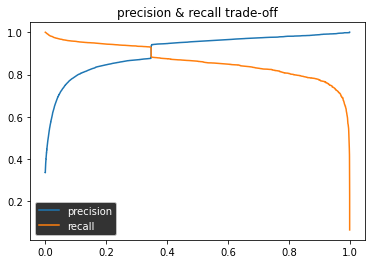

In [68]:
precision_array, recall_array, threshold_array = precision_recall_curve(y_test, y_pred)

plt.plot(threshold_array, precision_array[0:len(threshold_array)], label='precision')
plt.plot(threshold_array, recall_array[0:len(threshold_array)], label='recall')
plt.style.use('dark_background')

plt.title('precision & recall trade-off')
plt.legend(loc=0)

## 6. 베타테스트 시행

In [69]:
def model_test(comment):
    loaded_model = load_model('/content/drive/MyDrive/악성댓글_필터링_봇_모델/04_최종모델 [1D-CNN]/1D_CNN_best.h5')
    comment_list = [list(comment)]
    comment_label = tokenizer.texts_to_sequences(comment_list)

    comment_pad = pad_sequences(comment_label, padding='post', maxlen=400)

    pred = loaded_model.predict(comment_pad)

    if pred < 0.5 :
        result = '악플이 아닙니다'
    else :
        result = '악플입니다'
    
    print(result)
    print('라벨확률 : ', pred)
    
    return result, pred

In [20]:
comment = ''''''

result, prob = model_test(comment)

악플이 아닙니다
라벨확률 :  [[0.3381632]]
